Calculating SNR on brain MRI
----------------------------

SNR (signal to noise ratio) is a MUST-have NR-IQM (no reference, image quality metric) for quality assessment protocols.
The problem is, in theory, very easy. One just needs to apply the definition of the SNR of a signal:

In [1]:
def snr(img):
    fg_mean = img.mean()
    bg_std = img.std()
    return float(fg_mean / bg_std)

However, this definition is not directly applicable to MRI of the human brain. A first improvement would include two masks to indicate where signal and noise are computed.

In [2]:
def snr(img, smask, nmask):
    fg_mean = img[smask > 0].mean()
    bg_std = img[nmask > 0].std()
    return float(fg_mean / bg_std)

We may want to be able to compute signal and noise within the same object (typically the brightest tissue, the white-matter in T1-weighted images).

Additionally, we will also include [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction) for the variance calculation.

In [3]:
import numpy as np


def snr(img, smask, nmask=None):
    fg_mean = np.median(img[smask > 0])

    if nmask is None:
        nmask = smask

    # Manually compute sigma, using Bessel's correction (the - 1 in the normalizer)
    bg_mean = np.median(img[nmask > 0])
    bg_std = np.sqrt(np.sum((img[nmask > 0] - bg_mean) ** 2) / (np.sum(nmask) - 1))
    return float(fg_mean / bg_std)

Further improvement may include the correction proposed by [Dietrich et al. 2007](http://dx.doi.org/10.1002/jmri.20969), when a mask of the air surounding the head is calculated:

In [4]:
from math import pi
import numpy as np


def snr(img, smask, nmask=None):
    fg_mean = np.median(img[smask > 0])

    if nmask is None:
        nmask = smask
        # Manually compute sigma, using Bessel's correction (the - 1 in the normalizer)
        bg_mean = np.median(img[nmask > 0])
        bg_std = np.sqrt(np.sum((img[nmask > 0] - bg_mean) ** 2) / (np.sum(nmask) - 1))
    else:
        bg_std = np.sqrt(2.0/(4.0 - pi)) * img[nmask > 0].std(ddof=1)
    return float(fg_mean / bg_std)

Example
-------

Once we have defined our `snr` function, it is time to apply it in an image. We will first need to have some libraries available. Also we set the notebook in inline mode to show plots in the result of the cell.

In [5]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

We define a function to visualize the image

In [6]:
def plot_slice(fname, z_idx=100):

    # Load the image and collect the data
    # and orientation information
    img = nib.load(fname)
    data = img.get_data()
    aff = img.get_affine()

    # Find the center of the brain matrix
    ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

    # Plot the data
    vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
    plt.imshow(np.rot90(data[:, :, ctr[2] + z_idx]), 
               cmap="gray")
    plt.gca().set_axis_off()

We can now inspect the T1 image and the mask we will use to compute the SNR.

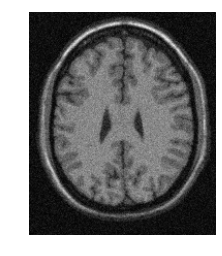

In [7]:
plot_slice("data/T1w-noise.nii.gz")

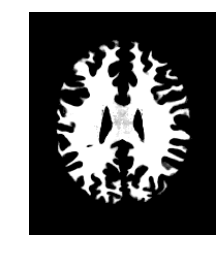

In [8]:
plot_slice("data/white.nii.gz")

Let's load the images:

In [9]:
im = nib.load('data/T1w-noise.nii.gz').get_data()
mask = nib.load('data/white.nii.gz').get_data()
mask[mask < 0.5] = 0
mask[mask >= 0.5] = 1
n = snr(im, mask)
print 'Estimated SNR=%.4f' % n 

Estimated SNR=9.9013
